Training improved A3C agent...
Episode 0, Average Reward: -1545.65


/var/folders/tt/3h_jlt8571z664b95jr80v_40000gn/T/ipykernel_43005/1688956323.py:263: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.FloatTensor(states)


Episode 100, Average Reward: -1442.94
Episode 200, Average Reward: -1484.70
Episode 300, Average Reward: -1447.18
Episode 400, Average Reward: -1475.15
Episode 500, Average Reward: -1482.54
Episode 600, Average Reward: -1423.24
Episode 700, Average Reward: -1443.71
Episode 800, Average Reward: -1584.66
Episode 900, Average Reward: -1455.50
Episode 1000, Average Reward: -1473.68
Episode 1100, Average Reward: -1515.95
Episode 1200, Average Reward: -1569.04
Episode 1300, Average Reward: -1529.86
Episode 1400, Average Reward: -1464.68
Episode 1500, Average Reward: -1435.98
Episode 1600, Average Reward: -1385.51
Episode 1700, Average Reward: -1535.26
Episode 1800, Average Reward: -1429.75
Episode 1900, Average Reward: -1509.75


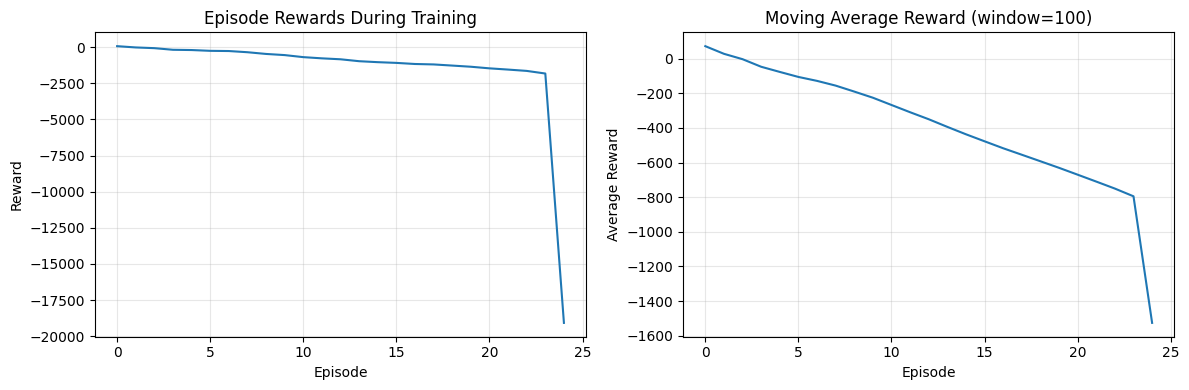


Evaluating trained agent...
Cumulative Profit - Mean: -18450.02, Std: 814.09, Max: -15829.10, Min: -20345.60


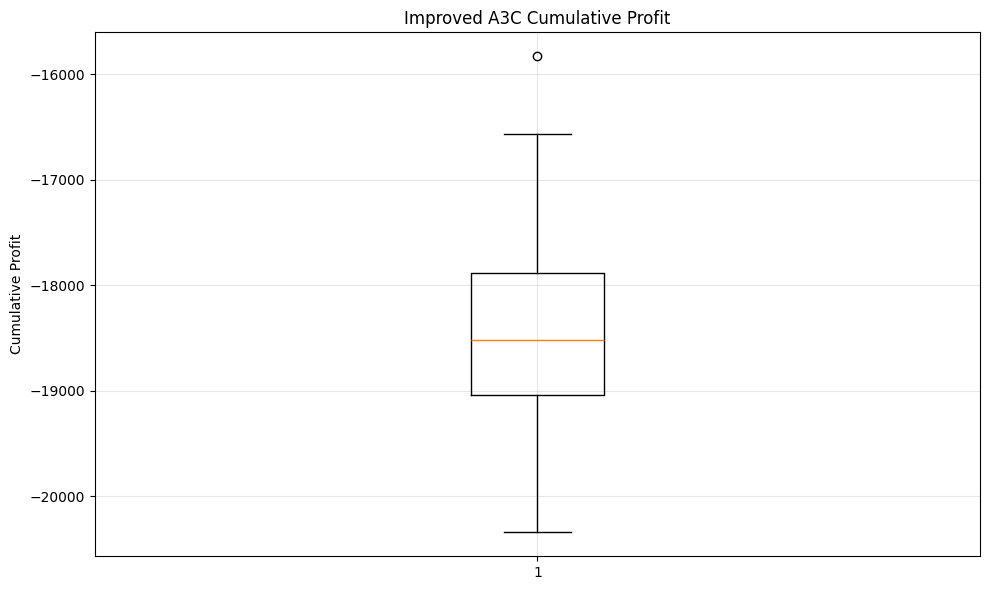

In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import gym
from gym.spaces import Box
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import random
import collections
import threading
import time

# Set random seeds for reproducibility
seed = 2021
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

class State:
    """State representation for supply chain environment"""
    
    def __init__(self, product_types_num, distr_warehouses_num, T, demand_history, t=0):
        self.product_types_num = product_types_num
        self.factory_stocks = np.zeros((self.product_types_num,), dtype=np.int32)
        self.distr_warehouses_num = distr_warehouses_num
        self.distr_warehouses_stocks = np.zeros(
            (self.distr_warehouses_num, self.product_types_num), dtype=np.int32)
        self.T = T
        self.demand_history = demand_history
        self.t = t

    def to_array(self):
        from itertools import chain
        return np.concatenate((
            self.factory_stocks,
            self.distr_warehouses_stocks.flatten(),
            np.hstack(list(chain(*chain(*self.demand_history)))),
            [self.t]))

    def stock_levels(self):
        return np.concatenate((
            self.factory_stocks,
            self.distr_warehouses_stocks.flatten()))

class Action:
    """Action representation for supply chain environment"""
    
    def __init__(self, product_types_num, distr_warehouses_num):
        self.production_level = np.zeros((product_types_num,), dtype=np.int32)
        self.shipped_stocks = np.zeros(
            (distr_warehouses_num, product_types_num), dtype=np.int32)

class SupplyChainEnvironment:
    """Supply chain environment implementation"""
    
    def __init__(self):
        self.product_types_num = 2
        self.distr_warehouses_num = 2
        self.T = 25
        
        self.d_max = np.array([3, 6], np.int32)
        self.d_var = np.array([2, 1], np.int32)
        
        self.sale_prices = np.array([20, 10], np.int32)
        self.production_costs = np.array([2, 1], np.int32)
        
        self.storage_capacities = np.array([[3, 4], [6, 8], [9, 12]], np.int32)
        self.storage_costs = np.array([[6, 3], [4, 2], [2, 1]], np.float32)
        self.transportation_costs = np.array([[.1, .3], [.2, .6]], np.float32)
        
        self.penalty_costs = .5 * self.sale_prices
        
        self.reset()

    def reset(self, demand_history_len=5):
        self.demand_history = collections.deque(maxlen=demand_history_len)
        for d in range(demand_history_len):
            self.demand_history.append(np.zeros(
                (self.distr_warehouses_num, self.product_types_num), dtype=np.int32))
        self.t = 0

    def demand(self, j, i, t):
        demand = np.round(
            self.d_max[i-1]/2 +
            self.d_max[i-1]/2*np.cos(4*np.pi*(2*j*i+t)/self.T) +
            np.random.randint(0, self.d_var[i-1]+1))
        return demand

    def initial_state(self):
        return State(self.product_types_num, self.distr_warehouses_num,
                     self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(
            lambda j, i: self.demand(j+1, i+1, self.t),
            (self.distr_warehouses_num, self.product_types_num),
            dtype=np.int32)

        next_state = State(self.product_types_num, self.distr_warehouses_num,
                          self.T, list(self.demand_history))

        next_state.factory_stocks = np.minimum(
            np.subtract(np.add(state.factory_stocks, action.production_level),
                       np.sum(action.shipped_stocks, axis=0)),
            self.storage_capacities[0])

        for j in range(self.distr_warehouses_num):
            next_state.distr_warehouses_stocks[j] = np.minimum(
                np.subtract(np.add(state.distr_warehouses_stocks[j],
                                  action.shipped_stocks[j]), demands[j]),
                self.storage_capacities[j+1])

        # Calculate reward
        total_revenues = np.dot(self.sale_prices, np.sum(demands, axis=0))
        total_production_costs = np.dot(self.production_costs, action.production_level)
        total_transportation_costs = np.dot(
            self.transportation_costs.flatten(), action.shipped_stocks.flatten())
        total_storage_costs = np.dot(
            self.storage_costs.flatten(),
            np.maximum(next_state.stock_levels(),
                      np.zeros(((self.distr_warehouses_num+1) * self.product_types_num),
                              dtype=np.int32)))
        total_penalty_costs = -np.dot(
            self.penalty_costs,
            np.add(np.sum(np.minimum(next_state.distr_warehouses_stocks,
                                   np.zeros((self.distr_warehouses_num, self.product_types_num),
                                           dtype=np.int32)), axis=0),
                  np.minimum(next_state.factory_stocks,
                           np.zeros((self.product_types_num,), dtype=np.int32))))

        reward = (total_revenues - total_production_costs - 
                 total_transportation_costs - total_storage_costs - total_penalty_costs)

        self.demand_history.append(demands)
        self.t += 1

        return next_state, reward, self.t == self.T-1

class SupplyChain(gym.Env):
    """Gym environment wrapper"""
    
    def __init__(self):
        self.reset()
        
        # Action space bounds - using continuous space but will round to integers
        low_act = np.zeros(
            ((self.supply_chain.distr_warehouses_num+1) * self.supply_chain.product_types_num),
            dtype=np.float32)
        high_act = np.zeros(
            ((self.supply_chain.distr_warehouses_num+1) * self.supply_chain.product_types_num),
            dtype=np.float32)
        high_act[:self.supply_chain.product_types_num] = np.sum(
            self.supply_chain.storage_capacities, axis=0).astype(np.float32)
        high_act[self.supply_chain.product_types_num:] = (
            self.supply_chain.storage_capacities.flatten()[self.supply_chain.product_types_num:]).astype(np.float32)
        
        self.action_space = Box(low=low_act, high=high_act, dtype=np.float32)
        
        # Observation space bounds
        low_obs = np.full((len(self.supply_chain.initial_state().to_array()),), -1000.0, dtype=np.float32)
        high_obs = np.full((len(self.supply_chain.initial_state().to_array()),), 1000.0, dtype=np.float32)
        
        self.observation_space = Box(low=low_obs, high=high_obs, dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array().astype(np.float32)

    def step(self, action):
        # Convert continuous actions to integers
        action = np.round(action).astype(np.int32)
        action = np.clip(action, 0, self.action_space.high.astype(np.int32))
        
        action_obj = Action(
            self.supply_chain.product_types_num,
            self.supply_chain.distr_warehouses_num)
        action_obj.production_level = action[:self.supply_chain.product_types_num]
        action_obj.shipped_stocks = action[self.supply_chain.product_types_num:].reshape(
            (self.supply_chain.distr_warehouses_num, self.supply_chain.product_types_num))

        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array().astype(np.float32), reward, done, {}

# Improved A3C Neural Network
class ImprovedA3CNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(ImprovedA3CNetwork, self).__init__()
        
        # Shared layers with layer normalization
        self.shared = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU()
        )
        
        # Actor head with proper initialization
        self.actor_mean = nn.Linear(hidden_size, action_size)
        self.actor_logstd = nn.Parameter(torch.zeros(action_size))
        
        # Critic head
        self.critic = nn.Linear(hidden_size, 1)
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                nn.init.constant_(m.bias, 0)
        
        # Small initialization for policy head
        nn.init.orthogonal_(self.actor_mean.weight, gain=0.01)
        nn.init.constant_(self.actor_mean.bias, 0)

    def forward(self, state):
        shared_features = self.shared(state)
        
        # Actor outputs
        action_mean = self.actor_mean(shared_features)
        action_std = torch.exp(self.actor_logstd.expand_as(action_mean))
        
        # Critic output
        value = self.critic(shared_features)
        
        return action_mean, action_std, value

# Improved A3C Agent
class ImprovedA3CAgent:
    def __init__(self, state_size, action_size, lr=1e-4, gamma=0.99, entropy_coef=0.01, value_coef=0.5):
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        
        self.network = ImprovedA3CNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr, eps=1e-5)
        
    def get_action_and_value(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_mean, action_std, value = self.network(state)
            
            dist = Normal(action_mean, action_std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)
            
        return action.squeeze().numpy(), log_prob.item(), value.item()
    
    def get_action(self, state):
        action, _, _ = self.get_action_and_value(state)
        return action
    
    def train_step(self, states, actions, rewards, next_states, dones, values):
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones)
        old_values = torch.FloatTensor(values)
        
        # Forward pass
        action_means, action_stds, current_values = self.network(states)
        _, _, next_values = self.network(next_states)
        
        # Calculate advantages using TD error
        target_values = rewards + self.gamma * next_values.squeeze() * (~dones).float()
        advantages = target_values - current_values.squeeze()
        
        # Detach advantages to prevent gradients flowing through value function
        advantages = advantages.detach()
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Calculate policy loss
        dist = Normal(action_means, action_stds)
        log_probs = dist.log_prob(actions).sum(dim=1)
        actor_loss = -(log_probs * advantages).mean()
        
        # Calculate entropy bonus
        entropy = dist.entropy().sum(dim=1).mean()
        
        # Calculate value loss
        value_loss = F.mse_loss(current_values.squeeze(), target_values.detach())
        
        # Total loss
        total_loss = actor_loss + self.value_coef * value_loss - self.entropy_coef * entropy
        
        # Optimization step
        self.optimizer.zero_grad()
        total_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), 0.5)
        
        self.optimizer.step()
        
        return {
            'total_loss': total_loss.item(),
            'actor_loss': actor_loss.item(),
            'value_loss': value_loss.item(),
            'entropy': entropy.item()
        }

def train_improved_a3c(env, episodes=2000, max_steps=25, update_freq=5):
    """Train improved A3C agent on the supply chain environment"""
    state_size = len(env.reset())
    action_size = env.action_space.shape[0]
    
    agent = ImprovedA3CAgent(state_size, action_size)
    episode_rewards = []
    
    # Storage for batch training
    batch_states = []
    batch_actions = []
    batch_rewards = []
    batch_next_states = []
    batch_dones = []
    batch_values = []
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        
        episode_states = []
        episode_actions = []
        episode_rewards = []
        episode_next_states = []
        episode_dones = []
        episode_values = []
        
        for step in range(max_steps):
            # Get action and value
            action, log_prob, value = agent.get_action_and_value(state)
            
            # Take step
            next_state, reward, done, _ = env.step(action)
            
            # Store transition
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            episode_next_states.append(next_state)
            episode_dones.append(done)
            episode_values.append(value)
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        # Add episode to batch
        batch_states.extend(episode_states)
        batch_actions.extend(episode_actions)
        batch_rewards.extend(episode_rewards)
        batch_next_states.extend(episode_next_states)
        batch_dones.extend(episode_dones)
        batch_values.extend(episode_values)
        
        episode_rewards.append(episode_reward)
        
        # Train agent every update_freq episodes
        if (episode + 1) % update_freq == 0 and len(batch_states) > 0:
            losses = agent.train_step(
                batch_states, batch_actions, batch_rewards,
                batch_next_states, batch_dones, batch_values
            )
            
            # Clear batch
            batch_states = []
            batch_actions = []
            batch_rewards = []
            batch_next_states = []
            batch_dones = []
            batch_values = []
        
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
            if (episode + 1) % update_freq == 0:
                print(f"  Losses - Total: {losses['total_loss']:.3f}, "
                      f"Actor: {losses['actor_loss']:.3f}, "
                      f"Value: {losses['value_loss']:.3f}, "
                      f"Entropy: {losses['entropy']:.3f}")
    
    return agent, episode_rewards

def simulate_episode(env, agent):
    """Simulate a single episode with trained agent"""
    state = env.reset()
    episode_reward = 0
    rewards = []
    
    for step in range(25):  # T = 25
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        episode_reward += reward
        
        state = next_state
        if done:
            break
    
    return episode_reward, rewards

def calculate_cum_profit(agent, env, num_episodes=200):
    """Calculate cumulative profit over multiple episodes"""
    cumulative_profits = []
    
    for _ in range(num_episodes):
        episode_reward, _ = simulate_episode(env, agent)
        cumulative_profits.append(episode_reward)
    
    print(f"Cumulative Profit - Mean: {np.mean(cumulative_profits):.2f}, "
          f"Std: {np.std(cumulative_profits):.2f}, "
          f"Max: {np.max(cumulative_profits):.2f}, "
          f"Min: {np.min(cumulative_profits):.2f}")
    
    return cumulative_profits

def visualize_cum_profit(cumulative_profits, title="Improved A3C Cumulative Profit"):
    """Visualize cumulative profit distribution"""
    plt.figure(figsize=(10, 6))
    plt.boxplot(cumulative_profits)
    plt.ylabel('Cumulative Profit')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_training_progress(episode_rewards):
    """Plot training progress"""
    plt.figure(figsize=(12, 4))
    
    # Plot episode rewards
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True, alpha=0.3)
    
    # Plot moving average
    plt.subplot(1, 2, 2)
    window = 100
    moving_avg = [np.mean(episode_rewards[max(0, i-window):i+1]) 
                  for i in range(len(episode_rewards))]
    plt.plot(moving_avg)
    plt.title(f'Moving Average Reward (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create environment
    env = SupplyChain()
    
    # Train improved A3C agent
    print("Training improved A3C agent...")
    agent, episode_rewards = train_improved_a3c(env, episodes=2000)
    
    # Plot training progress
    plot_training_progress(episode_rewards)
    
    # Evaluate trained agent
    print("\nEvaluating trained agent...")
    cumulative_profits = calculate_cum_profit(agent, env, num_episodes=200)
    
    # Visualize results
    visualize_cum_profit(cumulative_profits)